In [2]:
import mediapipe as mp
import cv2
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.misc import derivative
from scipy.signal import find_peaks
from statistics import stdev,mean
import itertools as itr
import pprint, pickle

# definitions

In [3]:
def time_diff(peaks):
    array=[]
    for i in range(len(peaks)-1):
        td=df.t[peaks[i+1]]-df.t[peaks[i]]
        array.append(td)
    return array

def get_peaks(df,y):
    peaks, _ = find_peaks(-y,prominence=0.03)
    plt.figure(figsize=(20,5))
    plt.plot(df.t,y)
    plt.plot(df.t[peaks], y[peaks],"X",markerfacecolor='red',markersize=8)
    plt.show()
    return peaks

def distribution(data):
    ax=sns.distplot(data,
                kde=True,
                bins=8,
                color='blue',
                hist_kws={"linewidth": 22,'alpha':0.60})
    ax.set(xlabel='Binomial',ylabel='Frequency')
    plt.show()
    
def remove_time_gap(data):
    from statistics import stdev,mean
    SD=stdev(data)
    m= mean(data)
 
    cut_off = SD * 0.5
    upper =  m + cut_off
    array = [x for x in data if x < upper]
    return array
    
def remove_distinc(array,df,Time_to_index_ratio,y):
    modified_mean= mean(array)
    Distance=Time_to_index_ratio*modified_mean*0.5
    
    peaks, _ = find_peaks(-y,prominence=0.03,distance=Distance)
    plt.figure(figsize=(20,5))
    plt.plot(df.t,y)
    plt.plot(df.t[peaks], y[peaks],"X",markerfacecolor='red',markersize=8)
    plt.show()
    return peaks

def sample(df,strike_peak,time_return_points):
    a = np.array(df.t[strike_peak])
    sample_strikes=[]
    index=np.where(np.logical_and(a>=time_return_points.t[0], a<=time_return_points.t[1]))
    s = list(map(lambda a : df.t[strike_peak[a]], index[0]))
    sample_strikes.append(s)
    return sample_strikes

def strides(sample_strikes):
    strides=[]
    for strike in sample_strikes:
        sample=[]
        for i in range(len(strike)-1):
            t_diff=strike[i+1]-strike[i]
            sample.append(t_diff)
        strides.append(sample)
    return strides

def com(A,B):
    if type(A)==np.ndarray:
        C= A.tolist()
    else:
        C=A
    for i,v in enumerate(B):
        C.insert(2*i+1,v) 
    return C
    
def step_time(right,left):
    L_array=[]
    R_array=[]
    try:
        if len(right)==len(left):
            if left[0]>right[0]:
                #print(1)
                Lstep=np.subtract(left,right) 
                L_array=Lstep
                Rstep=np.subtract(right[1:],left[:-1]) 
                R_array=Rstep
            else:
                #print(2)
                Rstep=np.subtract(right,left)
                R_array=Rstep
                Lstep=np.subtract(left[1:],right[:-1]) 
                L_array=Lstep

        elif (len(right)+1)==len(left):#when left strides are max by one
            if right[0]>left[0]:
                #print(3)
                Lstep=np.subtract(left[1:],right) 
                L_array=Lstep
                Rstep=np.subtract(right,left[:-1]) 
                R_array=Rstep

        elif len(right)==(len(left)+1):#when right strides are max by one
            if left[0]>right[0]:
                #print(4)
                Lstep=np.subtract(left,right[:-1]) 
                L_array=Lstep
                Rstep=np.subtract(right[1:],left) 
                R_array=Rstep

        else:
            #print(5)
            L_array.append('ooa')
            R_array.append('ooa')
    except:
        L_array.append('ooa')
        R_array.append('ooa')
        
    return R_array,L_array

def step_time_array(sample_strikes_R,sample_strikes_L):
    R_st_array=[]
    L_st_array=[]
    for i in range(len(sample_strikes_R)):
        if not len(sample_strikes_R[i])==0:
            Rst,Lst=step_time(sample_strikes_R[i],sample_strikes_L[i])
            R_st_array.append(Rst)
            L_st_array.append(Lst)
    return R_st_array,L_st_array
        
def time_diff_array(first,second):
    second_array=[]
    first_array=[]
    try:
        if len(first)==len(second):
            if second[0]>first[0]:
                #print(1)
                Lstep=np.subtract(second,first) 
                second_array=Lstep
                Rstep=np.subtract(first[1:],second[:-1]) 
                first_array=Rstep
            else:
                #print(2)
                Rstep=np.subtract(first,second)
                first_array=Rstep
                Lstep=np.subtract(second[1:],first[:-1]) 
                second_array=Lstep

        elif (len(first)+1)==len(second):#when left strides are max by one
            if first[0]>second[0]:
                #print(3)
                Lstep=np.subtract(second[1:],first) 
                second_array=Lstep
                Rstep=np.subtract(first,second[:-1]) 
                first_array=Rstep

        elif len(first)==(len(second)+1):#when right strides are max by one
            if second[0]>first[0]:
                #print(4)
                Lstep=np.subtract(second,first[:-1]) 
                second_array=Lstep
                Rstep=np.subtract(first[1:],second) 
                first_array=Rstep

        else:
            #print(5)
            second_array.append('ooa')
            first_array.append('ooa')
            
    except:
            second_array.append('ooa')
            first_array.append('ooa')
        


    return first_array,second_array

def swing_array(sample_strikes_hs,sample_strikes_to):
    try:
        swing_array=[]
        for i in range(len(sample_strikes_hs)):
            if not len(sample_strikes_hs[i])==0:
                #print(len(sample_strikes_plus_R[i]),len(sample_strikes_plus_L[i]))
                hs_to,_=time_diff_array(sample_strikes_hs[i],sample_strikes_to[i])
                swing_array.append(hs_to)
    except:
        swing_array=[None]
    return swing_array
        
def avrg(x):
    try:
        array=[]
        for i in x:
            if i==['ooa']:
                array.append(['ooa'])
            elif len(i)==0:
                array.append([])
            else:
                s=0
                for j in i:
                    s+=j
                m=s/len(i)
                array.append(m) 
    except:
        array=[None]
    return array

def double_support_time(to_R,hs_R,to_L,hs_L):
    array=[]
    if to_R==hs_L==hs_R==hs_L:
        if to_R[0]>hs_L[i][0]:
            dst1=np.subtract(to_R,hs_L)
            dst2=np.subtract(to_L[1:],hs_R)
            dst=np.add(dst1,dst2)
            array.append(dst)
        elif to_L[i][0]>hs_R[i][0]:
            dst1=np.subtract(to_R[1:],hs_L)
            dst2=np.subtract(to_L,hs_R)
            dst=np.add(dst1,dst2)
            array.append(dst)
        else:
            dst_array.append("ooa")
        return array
    else:
        return "ooa"   
    
def double_support_time_array(sample_strikes_to_R,sample_strikes_hs_R,sample_strikes_to_L,sample_strikes_hs_L):
    dst_array=[]
    for i in range(min(len(sample_strikes_to_R),len(sample_strikes_to_L))):
        if not len(sample_strikes_to_R[i])==0:
            array=double_support_time(sample_strikes_to_R[i],sample_strikes_hs_R[i],sample_strikes_to_L[i],sample_strikes_hs_L[i])
            dst_array.append(array)
    return dst_array

In [4]:
name='Geemanthi evidence 1'

In [5]:


f_file = open('{}'.format(name), 'rb')

key_array = pickle.load(f_file)
#pprint.pprint(fT)

f_file.close()


# anckle-hip length side

In [6]:
array=[]
for i in range(len(key_array)):
    t=key_array[i][28][3]
    right=abs(key_array[i][24][1]-key_array[i][28][1])
    left=abs(key_array[i][23][1]-key_array[i][27][1])
    heel_r=abs(key_array[i][24][1]-key_array[i][30][1])
    foot_index_r=abs(key_array[i][24][1]-key_array[i][32][1])
    heel_l=abs(key_array[i][23][1]-key_array[i][29][1])
    foot_index_l=abs(key_array[i][23][1]-key_array[i][31][1])
    x=key_array[i][28][0]
    center=(key_array[i][11][0]+key_array[i][12][0]+key_array[i][23][0]+key_array[i][24][0])/4
    array.append([right])
    array[i].append(left)
    array[i].append(heel_r)
    array[i].append(foot_index_r)
    array[i].append(heel_l)
    array[i].append(foot_index_l)
    array[i].append(t)
    array[i].append(x)
    array[i].append(center)
array = np.array(array)
print(array)

[[2.08234459e-01 1.96888894e-01 2.24627882e-01 ... 1.65849103e+09
  9.26751941e-02 9.59108267e-02]
 [1.97333485e-01 1.93961263e-01 2.12446898e-01 ... 1.65849103e+09
  9.26777944e-02 9.58471652e-02]
 [1.91923946e-01 1.89494044e-01 2.07006902e-01 ... 1.65849103e+09
  9.26895514e-02 9.49630775e-02]
 ...
 [1.85898185e-01 1.64303660e-01 2.05297053e-01 ... 1.65849105e+09
  9.52212155e-01 9.33225214e-01]
 [1.90288633e-01 1.61769956e-01 2.08427340e-01 ... 1.65849105e+09
  9.52015281e-01 9.37265500e-01]
 [1.94102198e-01 1.61992460e-01 2.10587531e-01 ... 1.65849105e+09
  9.52244759e-01 9.43384439e-01]]


In [7]:
df = pd.DataFrame(array,columns=['r','l','h_R','f_R','h_L','f_L','t','x','center'])
print(df)

            r         l       h_R       f_R       h_L       f_L             t  \
0    0.208234  0.196889  0.224628  0.232212  0.213284  0.218609  1.658491e+09   
1    0.197333  0.193961  0.212447  0.221139  0.208840  0.215299  1.658491e+09   
2    0.191924  0.189494  0.207007  0.214818  0.204129  0.210733  1.658491e+09   
3    0.190669  0.188262  0.204945  0.211698  0.202691  0.209186  1.658491e+09   
4    0.189079  0.186745  0.203121  0.213248  0.201491  0.207704  1.658491e+09   
..        ...       ...       ...       ...       ...       ...           ...   
161  0.184070  0.182359  0.200114  0.196224  0.195299  0.198682  1.658491e+09   
162  0.185007  0.168856  0.202275  0.197160  0.180123  0.198156  1.658491e+09   
163  0.185898  0.164304  0.205297  0.199196  0.171642  0.199524  1.658491e+09   
164  0.190289  0.161770  0.208427  0.201919  0.165613  0.190861  1.658491e+09   
165  0.194102  0.161992  0.210588  0.204761  0.163686  0.194882  1.658491e+09   

            x    center  
0

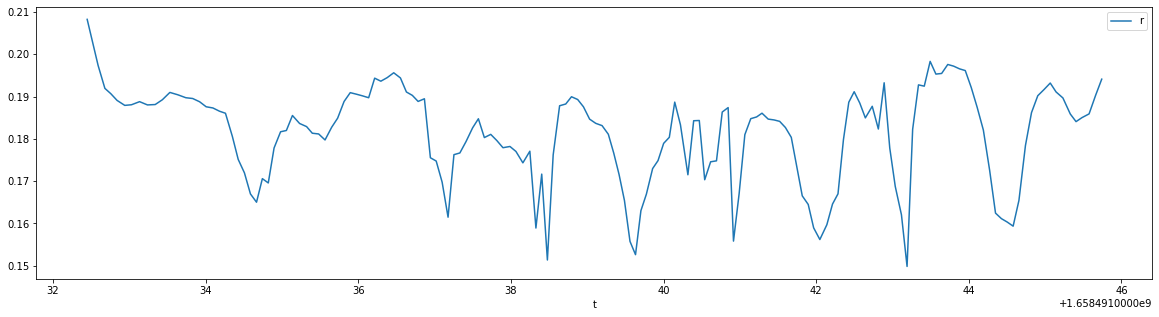

In [8]:
df.plot(x ='t', y='r', kind = 'line',figsize=(20,5))
plt.show()

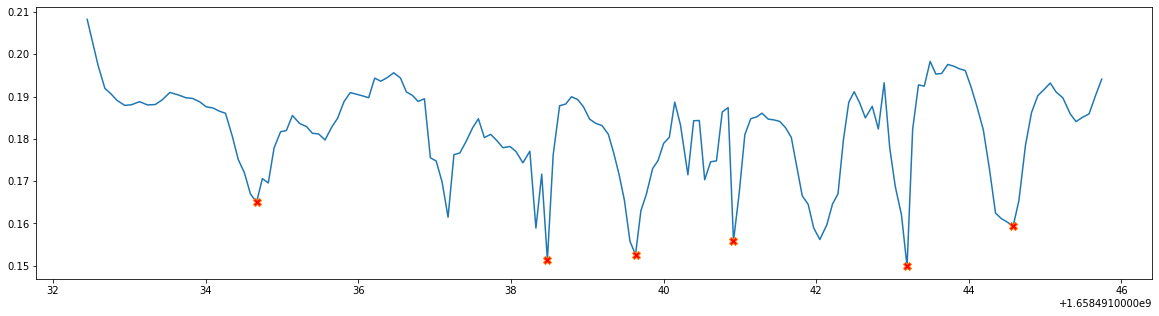

In [9]:
peaks=get_peaks(df,df.r)

In [10]:

Time_to_index_ratio=(peaks[1]-peaks[0])/(df.t[peaks[1]]-df.t[peaks[0]])
print(Time_to_index_ratio)

12.332843395289412


# walking direction

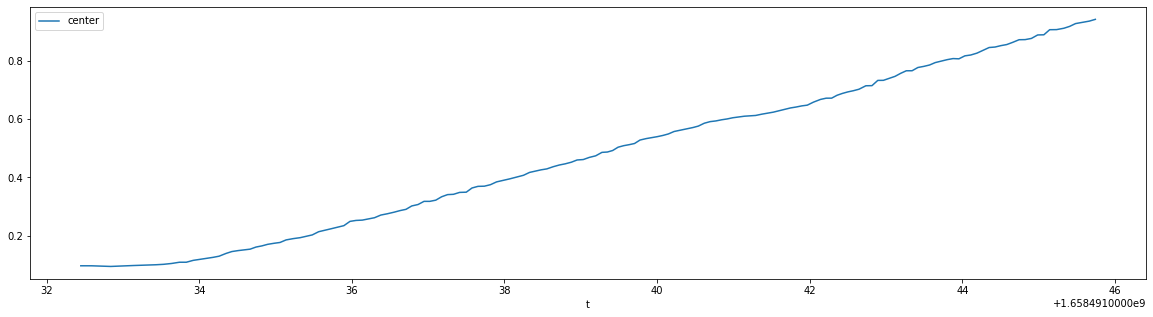

In [11]:
df.plot(x ='t', y='center', kind = 'line',figsize=(20,5))
plt.show()

In [12]:
plus=0
minus=1

In [13]:
if plus==1:
    df_plus=df
elif minus==1:
    df_minus=df
    
print(df_minus)
    
    
return_points=[0,len(df)-1]
time_return_points=pd.DataFrame(df.t[return_points],columns=['t']).reset_index()

            r         l       h_R       f_R       h_L       f_L             t  \
0    0.208234  0.196889  0.224628  0.232212  0.213284  0.218609  1.658491e+09   
1    0.197333  0.193961  0.212447  0.221139  0.208840  0.215299  1.658491e+09   
2    0.191924  0.189494  0.207007  0.214818  0.204129  0.210733  1.658491e+09   
3    0.190669  0.188262  0.204945  0.211698  0.202691  0.209186  1.658491e+09   
4    0.189079  0.186745  0.203121  0.213248  0.201491  0.207704  1.658491e+09   
..        ...       ...       ...       ...       ...       ...           ...   
161  0.184070  0.182359  0.200114  0.196224  0.195299  0.198682  1.658491e+09   
162  0.185007  0.168856  0.202275  0.197160  0.180123  0.198156  1.658491e+09   
163  0.185898  0.164304  0.205297  0.199196  0.171642  0.199524  1.658491e+09   
164  0.190289  0.161770  0.208427  0.201919  0.165613  0.190861  1.658491e+09   
165  0.194102  0.161992  0.210588  0.204761  0.163686  0.194882  1.658491e+09   

            x    center  
0

# plus direction------------------------------------------------------------------------------------

# Right leg

# walking left to right-plus direction

In [14]:
if plus==1:
    peaks=get_peaks(df_plus,df_plus.r)

    dt_plus_right=time_diff(peaks)
    print(dt_plus_right)
    distribution(dt_plus_right)


    dt_plus_right_new=remove_time_gap(dt_plus_right)
    print(dt_plus_right_new)
    distribution(dt_plus_right_new)

    plus_peaks_R=remove_distinc(dt_plus_right,df_plus,Time_to_index_ratio,df_plus.r)

    dt_plus_right=time_diff(plus_peaks_R)
    dt_plus_right_cleaned=remove_time_gap(dt_plus_right)
    distribution(dt_plus_right_cleaned)


# minus direction--------------------------------------------------------------------------------------

# Walking right to Left - minus direction

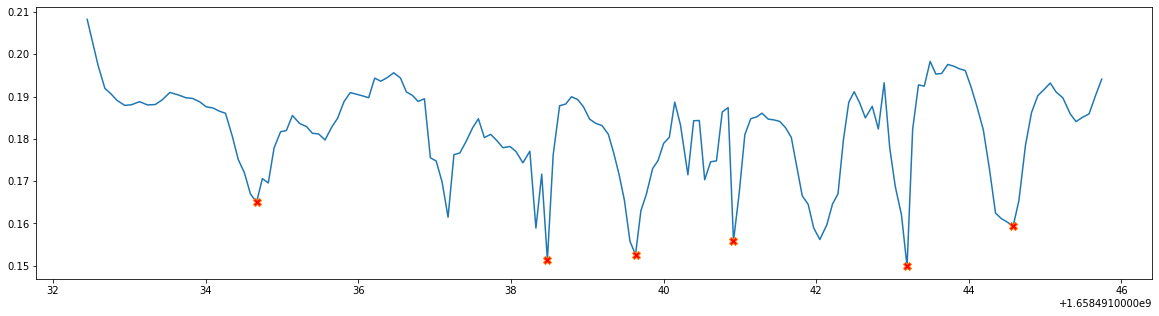

[3.810962200164795, 1.1545679569244385, 1.2835960388183594, 2.2742068767547607, 1.3897409439086914]


/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


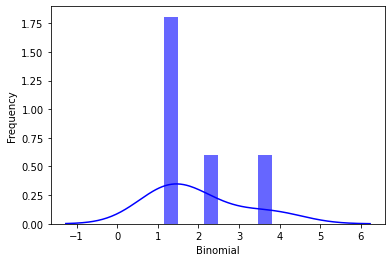

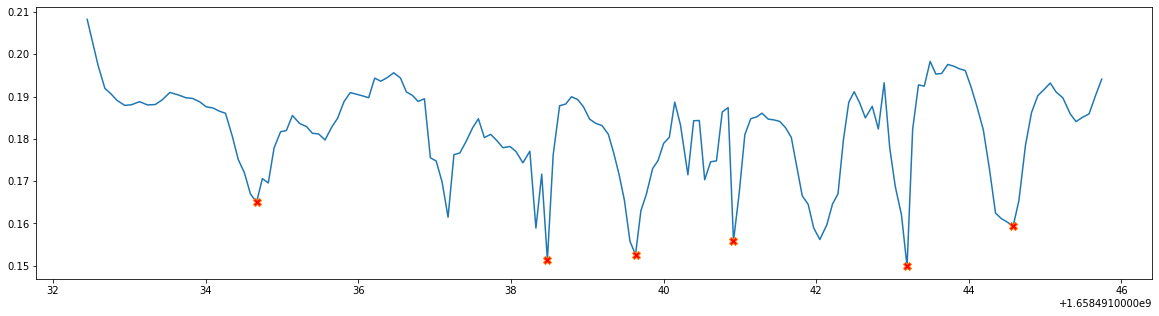

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


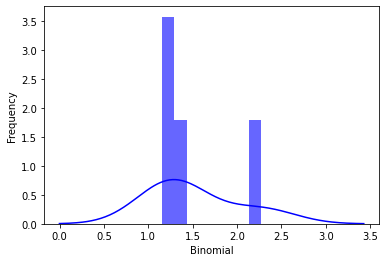

In [15]:
if minus==1:
    peaks=get_peaks(df_minus,df_minus.r)

    dt_minus_right=time_diff(peaks)
    print(dt_minus_right)
    distribution(dt_minus_right)

    minus_peaks_R=remove_distinc(dt_minus_right,df_minus,Time_to_index_ratio,df_minus.r)

    dt_minus_right=time_diff(minus_peaks_R)
    dt_minus_right_cleaned=remove_time_gap(dt_minus_right)
    distribution(dt_minus_right_cleaned)

# sampling- right leg

In [16]:
if plus==1:
    sample_strikes_plus_R=sample(df_plus,plus_peaks_R,time_return_points)
    strides_plus_R=strides(sample_strikes_plus_R)
    print(strides_plus_R)
    
    avg_stride_plus_R=list(map(lambda a : np.mean(a), strides_plus_R))
    print(avg_stride_plus_R)

if minus==1:
    sample_strikes_minus_R=sample(df_minus,minus_peaks_R,time_return_points)
    strides_minus_R=strides(sample_strikes_minus_R)
    print(strides_minus_R)
    
    
    avg_stride_minus_R=list(map(lambda a : np.mean(a), strides_minus_R))
    print(avg_stride_minus_R)

[[3.810962200164795, 1.1545679569244385, 1.2835960388183594, 2.2742068767547607, 1.3897409439086914]]
[1.982614803314209]


# Left leg

# walking left to right-plus direction

In [17]:
if plus==1:
    peaks=get_peaks(df_plus,df_plus.l)
    
    dt_plus_left=time_diff(peaks)
    print(dt_plus_left)
    distribution(dt_plus_left)
    
    plus_peaks_L=remove_distinc(dt_plus_left,df_plus,Time_to_index_ratio,df_plus.l)
    
    dt_minus_right=time_diff(minus_peaks_R)
    dt_minus_right_cleaned=remove_time_gap(dt_minus_right)
    distribution(dt_minus_right_cleaned)

# Walking right to Left - minus direction

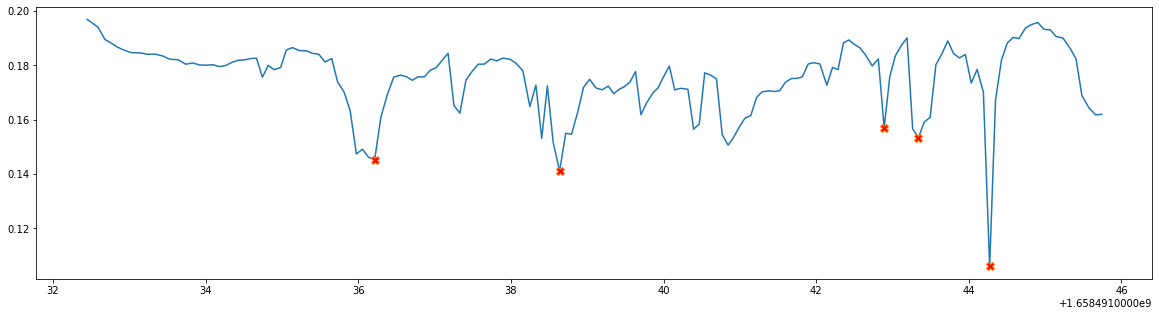

[2.422917604446411, 4.252237796783447, 0.4497079849243164, 0.9324731826782227]


/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


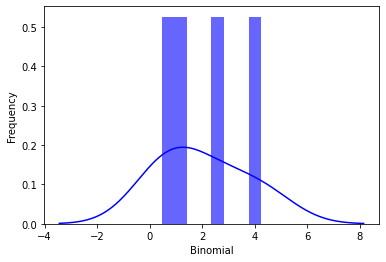

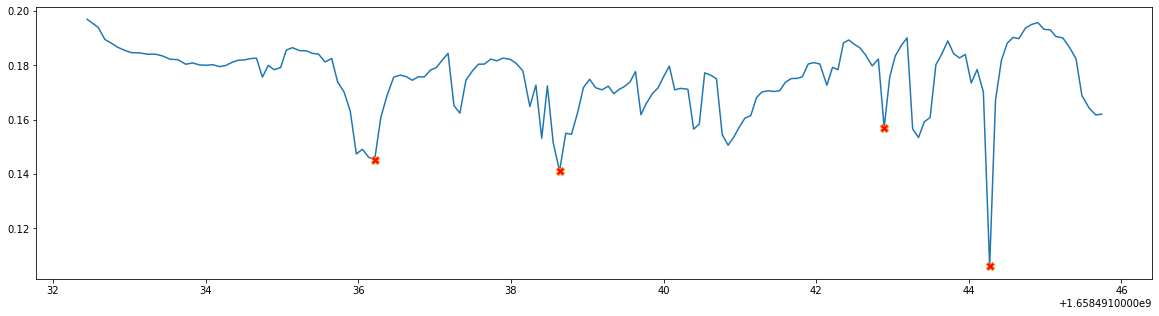

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


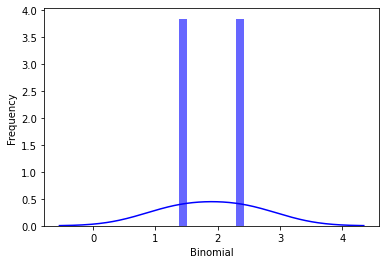

In [18]:
if minus==1:
    peaks=get_peaks(df_minus,df_minus.l)
    
    dt_minus_left=time_diff(peaks)
    print(dt_minus_left)
    distribution(dt_minus_left)
    
    minus_peaks_L=remove_distinc(dt_minus_left,df_minus,Time_to_index_ratio,df_minus.l)
    
    dt_minus_left=time_diff(minus_peaks_L)
    dt_minus_left_cleaned=remove_time_gap(dt_minus_left)
    distribution(dt_minus_left_cleaned)

# sampling-left leg

In [19]:
if plus==1:
    sample_strikes_plus_L=sample(df_plus,plus_peaks_L,time_return_points)
    strides_plus_L=strides(sample_strikes_plus_L)
    print(strides_plus_L)
    
    avg_stride_plus_L=list(map(lambda a : np.mean(a), strides_plus_L))
    print(avg_stride_plus_L)
    
elif minus==1:
    sample_strikes_minus_L=sample(df_minus,minus_peaks_L,time_return_points)
    strides_minus_L=strides(sample_strikes_minus_L)
    print(strides_minus_L)
    
    avg_stride_minus_L=list(map(lambda a : np.mean(a), strides_minus_L))
    print(avg_stride_minus_L)



[[2.422917604446411, 4.252237796783447, 1.382181167602539]]
[2.685778856277466]


# define feature vector array

In [20]:
TP_side=[]
T_s=[[[None],[None]],[[None],[None]],[[None],[None]],[[None],[None]],[None],[None],[None],[None]]

# stride time 

In [21]:
if plus==1:
    T3=avg_stride_plus_R
    T4=avg_stride_plus_L
    
elif minus==1:
    T3=avg_stride_minus_R
    T4=avg_stride_minus_L
    
T_s[1][0]=T3
T_s[1][1]=T4

# plus direction

In [22]:
if plus==1:
    plt.figure(figsize=(20,5))
    plt.plot(df_plus.t,df_plus.l,'b')
    plt.plot(df_plus.t,df_plus.r,'r')
    plt.plot(df_plus.t[plus_peaks_L], df_plus.l[plus_peaks_L],"X",markerfacecolor='red',markersize=8)
    plt.plot(df_plus.t[plus_peaks_R], df_plus.r[plus_peaks_R],"X",markerfacecolor='black',markersize=8)
    plt.show()
    
    print(sample_strikes_plus_L)
    print(sample_strikes_plus_R)

    step_plus_R,_=step_time_array(sample_strikes_plus_R,sample_strikes_plus_L)
    step_plus_L,_=step_time_array(sample_strikes_plus_L,sample_strikes_plus_R)
    
    print(step_plus_R)
    print(step_plus_L)
    
    avg_step_plus_L=list(map(lambda a : np.mean(a) if a!=['ooa'] else ['ooa'], step_plus_L))
    avg_step_plus_R=list(map(lambda a : np.mean(a) if a!=['ooa'] else ['ooa'], step_plus_R))

# minus direction

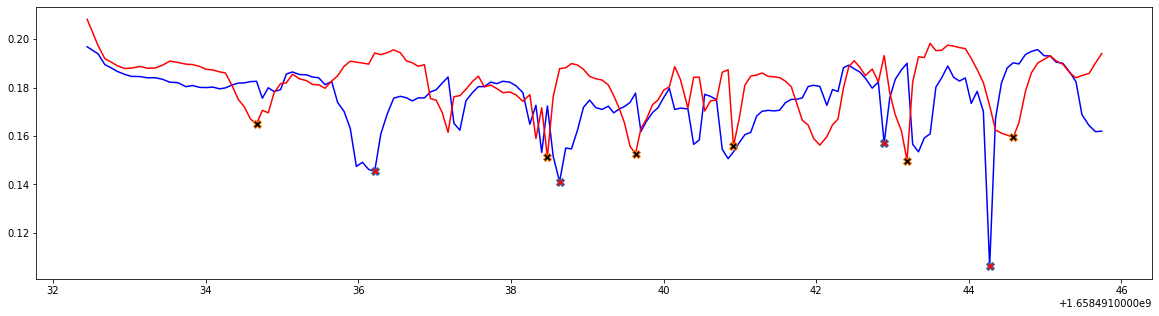

[[1658491036.2156782, 1658491038.6385958, 1658491042.8908336, 1658491044.2730148]]
[[1658491034.6676588, 1658491038.478621, 1658491039.633189, 1658491040.916785, 1658491043.1909919, 1658491044.5807328]]
[['ooa']] [['ooa']]
[['ooa']] [['ooa']]


In [23]:
if minus==1:
    plt.figure(figsize=(20,5))
    plt.plot(df_minus.t,df_minus.l,'b')
    plt.plot(df_minus.t,df_minus.r,'r')
    plt.plot(df_minus.t[minus_peaks_L], df_minus.l[minus_peaks_L],"X",markerfacecolor='red',markersize=8)
    plt.plot(df_minus.t[minus_peaks_R], df_minus.r[minus_peaks_R],"X",markerfacecolor='black',markersize=8)
    plt.show()

    print(sample_strikes_minus_L)
    print(sample_strikes_minus_R)


    step_minus_R,_=step_time_array(sample_strikes_minus_R,sample_strikes_minus_L)
    step_minus_L,_=step_time_array(sample_strikes_minus_L,sample_strikes_minus_R)

    print(step_minus_R,step_minus_L)
    

    avg_step_minus_L=list(map(lambda a : np.mean(a) if a!=['ooa'] else ['ooa'], step_minus_L))
    avg_step_minus_R=list(map(lambda a : np.mean(a) if a!=['ooa'] else ['ooa'], step_minus_R))
    
    print(avg_step_minus_L,avg_step_minus_R)

In [24]:
if plus==1:
    T1=avg_step_plus_R
    T2=avg_step_plus_L
elif minus==1:
    T1=avg_step_minus_R
    T2=avg_step_minus_L

T_s[0][0]=T1
T_s[0][1]=T2

# find heel strike and toe-off time-Right

# plus direction-Right

In [25]:
if plus==1:
    h_valley_plus_R, _ = find_peaks(-df_plus.h_R,prominence=0.05)
    f_valley_plus_R, _ = find_peaks(-df_plus.f_R,prominence=0.025)
    plt.figure(figsize=(20,5))
    plt.plot(df_plus.t,df_plus.h_R,'b')
    plt.plot(df_plus.t,df_plus.f_R,'r')
    plt.plot(df_plus.t[h_valley_plus_R], df_plus.h_R[h_valley_plus_R],"X",markerfacecolor='red',markersize=8)
    plt.plot(df_plus.t[f_valley_plus_R], df_plus.f_R[f_valley_plus_R],"X",markerfacecolor='black',markersize=8)
    plt.show()

    print('toe off')
    
    if len(h_valley_plus_R)>1:
            #toe off
        #toe off
        dt_plus_to_r=time_diff(h_valley_plus_R)
        distribution(dt_plus_to_r)
        dt_plus_to_r_new=remove_time_gap(dt_plus_to_r)
        distribution(dt_plus_to_r_new)
        plus_peaks_to_r=remove_distinc(dt_plus_to_r,df_plus,Time_to_index_ratio,df_plus.h_R)
        dt_plus_to_r=time_diff(plus_peaks_to_r)
        dt_plus_to_r_cleaned=remove_time_gap(dt_plus_to_r)
        distribution(dt_plus_to_r_cleaned)
    else:
        dt_plus_to_r_cleaned=[None]
                              
                              
    if len(f_valley_plus_R)>1:
        print('heel strike')
    
            #heel strike
        dt_plus_hs_r=time_diff(f_valley_plus_R)
        distribution(dt_plus_hs_r)
        dt_plus_hs_r_new=remove_time_gap(dt_plus_hs_r)
        distribution(dt_plus_hs_r_new)
        plus_peaks_hs_r=remove_distinc(dt_plus_hs_r,df_plus,Time_to_index_ratio,df_plus.f_R)
        dt_plus_hs_r=time_diff(plus_peaks_hs_r)
        dt_plus_hs_r_cleaned=remove_time_gap(dt_plus_hs_r)
        distribution(dt_plus_hs_r_cleaned)
    
    else:
        dt_plus_hs_r_cleaned=[None]
    
    sample_strikes_plus_hs_R=sample(df_plus,plus_peaks_hs_r,time_return_points)
    sample_strikes_plus_to_R=sample(df_plus,plus_peaks_to_r,time_return_points)

# minus direction-Right

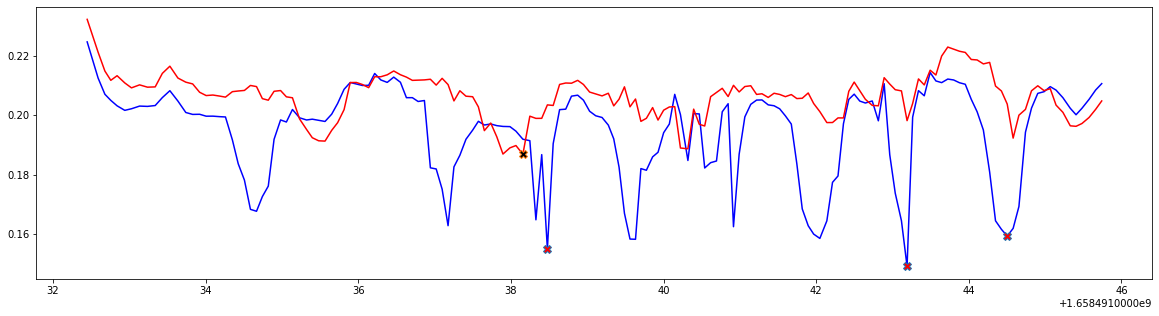

[ 71 133 150] [67]
toe off


/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


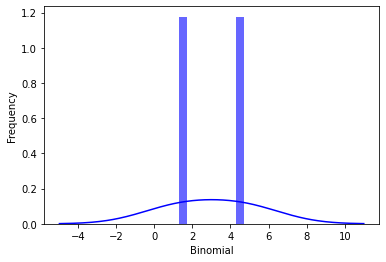

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


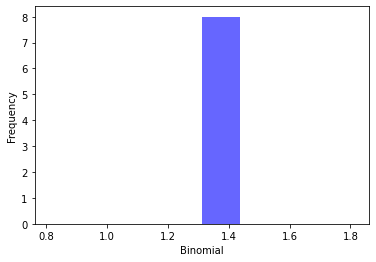

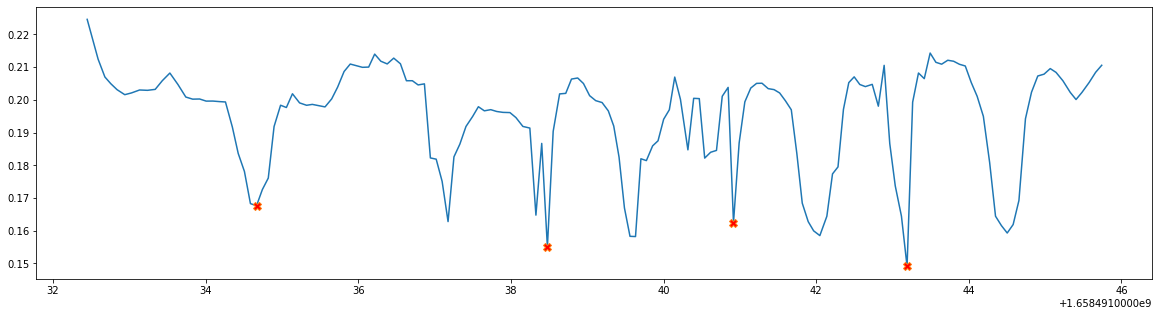

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


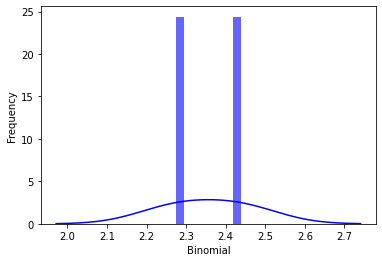

[None] [[1658491034.6676588, 1658491038.478621, 1658491040.916785, 1658491043.1909919]]


In [26]:
if minus==1:
    h_valley_minus_R, _ = find_peaks(-df_minus.h_R,prominence=0.05)
    f_valley_minus_R, _ = find_peaks(-df_minus.f_R,prominence=0.025)
    plt.figure(figsize=(20,5))
    plt.plot(df_minus.t,df_minus.h_R,'b')
    plt.plot(df_minus.t,df_minus.f_R,'r')
    plt.plot(df_minus.t[h_valley_minus_R], df_minus.h_R[h_valley_minus_R],"X",markerfacecolor='red',markersize=8)
    plt.plot(df_minus.t[f_valley_minus_R], df_minus.f_R[f_valley_minus_R],"X",markerfacecolor='black',markersize=8)
    plt.show()
    
    print(h_valley_minus_R,f_valley_minus_R)
    
    print('toe off')
    
    if len(h_valley_minus_R)>1:
            #toe off
        dt_minus_to_r=time_diff(h_valley_minus_R)
        distribution(dt_minus_to_r)
        dt_minus_to_r_new=remove_time_gap(dt_minus_to_r)
        distribution(dt_minus_to_r_new)
        minus_peaks_to_r=remove_distinc(dt_minus_to_r,df_minus,Time_to_index_ratio,df_minus.h_R)
        dt_minus_to_r=time_diff(minus_peaks_to_r)
        dt_minus_to_r_cleaned=remove_time_gap(dt_minus_to_r)
        distribution(dt_minus_to_r_cleaned)
        
        sample_strikes_minus_to_R=sample(df_minus,minus_peaks_to_r,time_return_points)
        
    else:
        dt_minus_to_r_cleaned=[None]
        sample_strikes_minus_to_R=[None]
                              
                              
    if len(f_valley_minus_R)>1:
        print('heel strike')
            #heel strike
        dt_minus_hs_r=time_diff(f_valley_minus_R)
        distribution(dt_minus_hs_r)
        dt_minus_hs_r_new=remove_time_gap(dt_minus_hs_r)
        distribution(dt_minus_hs_r_new)
        minus_peaks_hs_r=remove_distinc(dt_minus_hs_r,df_minus,Time_to_index_ratio,df_minus.f_R)
        dt_minus_hs_r=time_diff(minus_peaks_hs_r)
        dt_minus_hs_r_cleaned=remove_time_gap(dt_minus_hs_r)
        distribution(dt_minus_hs_r_cleaned)
        
        sample_strikes_minus_hs_R=sample(df_minus,minus_peaks_hs_r,time_return_points)
    else:
        dt_minus_hs_r_cleaned=[None]
        sample_strikes_minus_hs_R=[None]
    
    print(sample_strikes_minus_hs_R,sample_strikes_minus_to_R)
    
    
    

    


# find heel strike and toe-off time-left

# Plus direction-left

In [27]:
if plus==1:
    
    h_valley_plus_L, _ = find_peaks(-df_plus.h_L,prominence=0.05)
    f_valley_plus_L, _ = find_peaks(-df_plus.f_L,prominence=0.02)
    plt.figure(figsize=(20,5))
    plt.plot(df_plus.t,df_plus.h_L,'b')
    plt.plot(df_plus.t,df_plus.f_L,'r')
    plt.plot(df_plus.t[h_valley_plus_L], df_plus.h_L[h_valley_plus_L],"X",markerfacecolor='red',markersize=8)
    plt.plot(df_plus.t[f_valley_plus_L], df_plus.f_L[f_valley_plus_L],"X",markerfacecolor='black',markersize=8)
    plt.show()
    
    if len(h_valley_plus_L)>1:
    
    #toe off
        dt_plus_to_l=time_diff(h_valley_plus_L)
        distribution(dt_plus_to_l)
        dt_plus_to_l_new=remove_time_gap(dt_plus_to_l)
        distribution(dt_plus_to_l_new)
        plus_peaks_to_l=remove_distinc(dt_plus_to_l,df_plus,Time_to_index_ratio,df_plus.h_L)
        dt_plus_to_l=time_diff(plus_peaks_to_l)
        dt_plus_to_l_cleaned=remove_time_gap(dt_plus_to_l)
        distribution(dt_plus_to_l_cleaned)
        
        sample_strikes_plus_to_L=sample(df_plus,plus_peaks_to_l,time_return_points)
        
    else:
        dt_plus_to_l_cleaned=[None]
        sample_strikes_plus_to_L=[None]
        
    if len(f_valley_plus_L)>1:
        #heel strike
        dt_plus_hs_l=time_diff(f_valley_plus_L)
        distribution(dt_plus_hs_l)
        dt_plus_hs_l_new=remove_time_gap(dt_plus_hs_l)
        distribution(dt_plus_hs_l_new)
        plus_peaks_hs_l=remove_distinc(dt_plus_hs_l,df_plus,Time_to_index_ratio,df_plus.f_L)
        dt_plus_hs_l=time_diff(plus_peaks_hs_l)
        dt_plus_hs_l_cleaned=remove_time_gap(dt_plus_hs_l)
        distribution(dt_plus_hs_l_cleaned)
        
        sample_strikes_plus_hs_L=sample(df_plus,plus_peaks_hs_l,time_return_points)
        
    else:
        dt_plus_hs_l_cleaned=[None]
        sample_strikes_plus_hs_L=[None]
        

# minus-direction-left

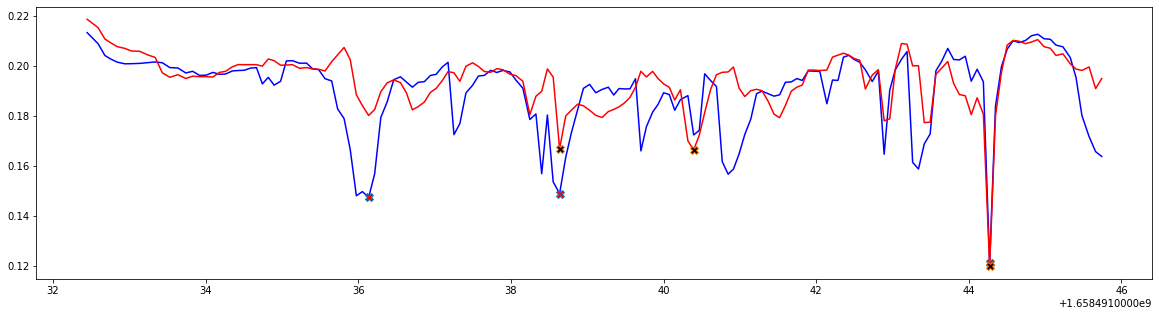

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


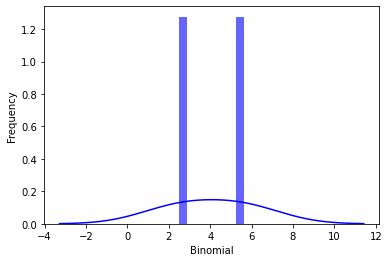

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


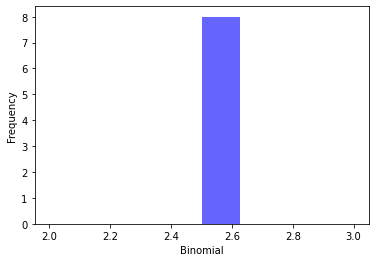

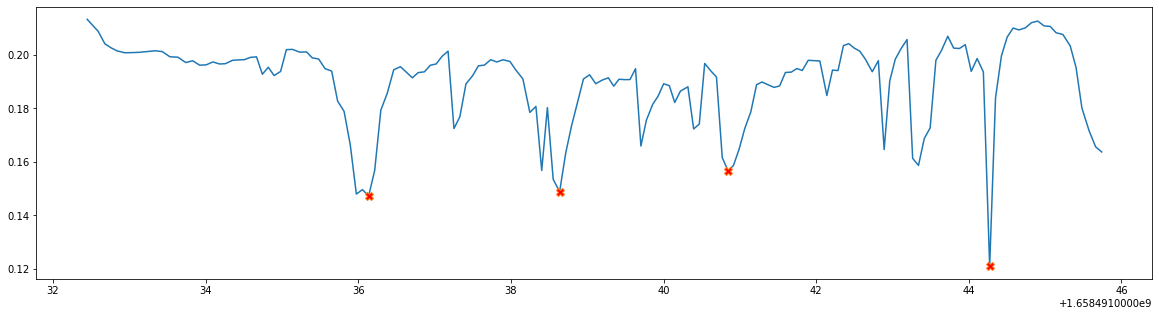

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


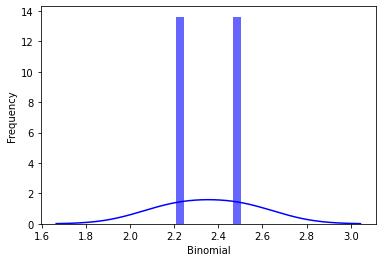

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


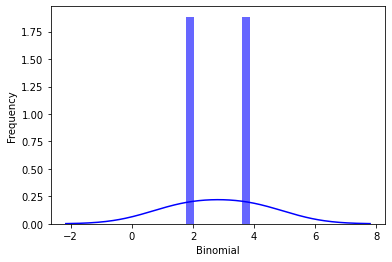

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


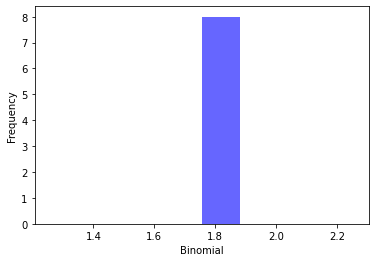

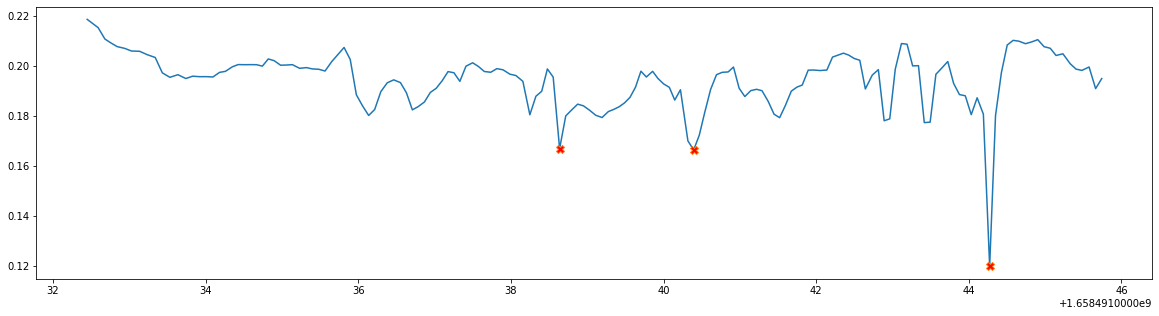

/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/jayasanka/.local/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


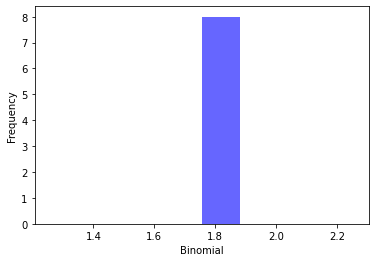

In [37]:
if minus==1:
    
    h_valley_minus_L, _ = find_peaks(-df_minus.h_L,prominence=0.05)
    f_valley_minus_L, _ = find_peaks(-df_minus.f_L,prominence=0.03)
    plt.figure(figsize=(20,5))
    plt.plot(df_minus.t,df_minus.h_L,'b')
    plt.plot(df_minus.t,df_minus.f_L,'r')
    plt.plot(df_minus.t[h_valley_minus_L], df_minus.h_L[h_valley_minus_L],"X",markerfacecolor='red',markersize=8)
    plt.plot(df_minus.t[f_valley_minus_L], df_minus.f_L[f_valley_minus_L],"X",markerfacecolor='black',markersize=8)
    plt.show()
    
    if len(h_valley_minus_L)>1 :
        #toe off
        dt_minus_to_l=time_diff(h_valley_minus_L)
        distribution(dt_minus_to_l)
        dt_minus_to_l_new=remove_time_gap(dt_minus_to_l)
        distribution(dt_minus_to_l_new)
        minus_peaks_to_l=remove_distinc(dt_minus_to_l,df_minus,Time_to_index_ratio,df_minus.h_L)
        dt_minus_to_l=time_diff(minus_peaks_to_l)
        dt_minus_to_l_cleaned=remove_time_gap(dt_minus_to_l)
        distribution(dt_minus_to_l_cleaned)
        sample_strikes_minus_to_L=sample(df_minus,minus_peaks_to_l,time_return_points)
        
    else:
        dt_minus_to_l_cleaned=[None]
        sample_strikes_minus_hs_L=[None]
        
    if len(f_valley_minus_L)>1:
        #heel strike
        dt_minus_hs_l=time_diff(f_valley_minus_L)
        distribution(dt_minus_hs_l)
        dt_minus_hs_l_new=remove_time_gap(dt_minus_hs_l)
        distribution(dt_minus_hs_l_new)
        minus_peaks_hs_l=remove_distinc(dt_minus_hs_l,df_minus,Time_to_index_ratio,df_minus.f_L)
        dt_minus_hs_l=time_diff(minus_peaks_hs_l)
        dt_minus_hs_l_cleaned=remove_time_gap(dt_minus_hs_l)
        distribution(dt_minus_hs_l_cleaned)
        
        sample_strikes_minus_hs_L=sample(df_minus,minus_peaks_hs_l,time_return_points)
        
    else:
        dt_minus_hs_l_cleaned=[None]
        sample_strikes_minus_to_L=[None]

# Calculate swing time

In [38]:
if plus==1:
    swing_array_plus_R=swing_array(sample_strikes_plus_hs_R,sample_strikes_plus_to_R)
    print(swing_array_plus_R)
    
    swing_array_plus_L=swing_array(sample_strikes_plus_hs_L,sample_strikes_plus_to_L)
    print(swing_array_plus_L)
    
    avg_swing_plus_R=avrg(swing_array_plus_R)
    avg_swing_plus_L=avrg(swing_array_plus_L)

In [39]:
print(sample_strikes_minus_hs_L,sample_strikes_minus_to_L)

[[1658491038.6385958, 1658491040.3950868, 1658491044.2730148]] [[1658491036.136875, 1658491038.6385958, 1658491040.8464994, 1658491044.2730148]]


In [40]:
if minus==1:
    swing_array_minus_R=swing_array(sample_strikes_minus_hs_R,sample_strikes_minus_to_R)
    swing_array_minus_L=swing_array(sample_strikes_minus_hs_L,sample_strikes_minus_to_L)
    
    avg_swing_minus_R=avrg(swing_array_minus_R)
    avg_swing_minus_L=avrg(swing_array_minus_L)

/tmp/ipykernel_89615/4123394407.py:190: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if i==['ooa']:


In [41]:
if plus==1:
    T7=avg_swing_plus_R
    T8=avg_swing_plus_L
    
elif minus==1:
    T7=avg_swing_minus_R
    T8=avg_swing_minus_L

T_s[3][0]=T7
T_s[3][1]=T8

In [42]:
output = open('Para_values_{}.pkl'.format(name), 'wb')
pickle.dump(T_s, output)
output.close()

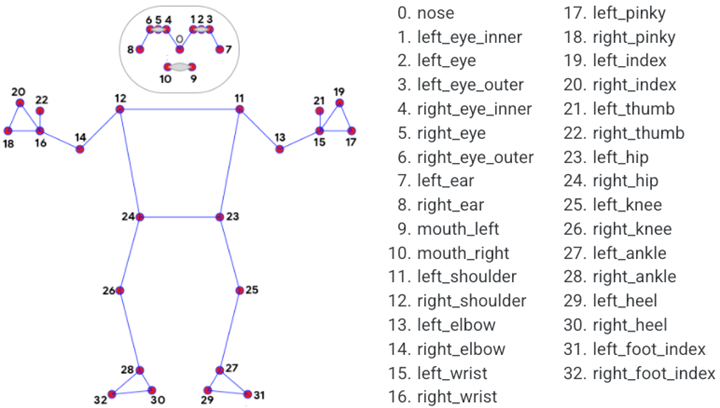